Testing new pipeline 

In [1]:
import os

os.environ["ABI_VISUAL_CODING_SDK_CACHE"] = "/space/scratch/allen_viscoding_data"
os.environ["ABI_VISUAL_BEHAVIOUR_SDK_CACHE"] = "/space/scratch/allen_visbehave_data"
os.environ["IBL_ONEAPI_CACHE"] = "/space/scratch/IBL_data_cache"

In [3]:
# United SWR detector
import os
import subprocess
import numpy as np
import pandas as pd
from scipy import io, signal, stats
from scipy.signal import lfilter, hilbert, fftconvolve
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import matplotlib.pyplot as plt
import ripple_detection
from ripple_detection import filter_ripple_band
import ripple_detection.simulate as ripsim  # for making our time vectors
from tqdm import tqdm
import time
import traceback
import logging
import logging.handlers
import sys
from multiprocessing import Pool, Process, Queue, Manager, set_start_method
import yaml
import string

# Get loader type from environment variable with a default value
#DATASET_TO_PROCESS = os.environ.get('DATASET_TO_PROCESS', 'ibl').lower()
DATASET_TO_PROCESS = 'abi_visual_behaviour'
valid_datasets = ['ibl', 'abi_visual_behaviour', 'abi_visual_coding']
if DATASET_TO_PROCESS not in valid_datasets:
    raise ValueError(f"DATASET_TO_PROCESS must be one of {valid_datasets}, got '{DATASET_TO_PROCESS}'")


# Lazy loading of the appropriate loader class
if DATASET_TO_PROCESS == 'ibl':
    from IBL_loader import ibl_loader
elif DATASET_TO_PROCESS == 'abi_visual_behaviour':
    from ABI_visual_behaviour_loader import abi_visual_behaviour_loader
elif DATASET_TO_PROCESS == 'abi_visual_coding':
    from ABI_visual_coding_loader import abi_visual_coding_loader
else:
    raise ValueError(f"Unknown dataset type: {DATASET_TO_PROCESS}")

# Load the configuration from a YAML file
config_path = os.environ.get('CONFIG_PATH', 'united_detector_config.yaml')
with open(config_path, "r") as f:
    # Parse the YAML content
    raw_content = f.read()
    # Replace environment variables
    for key, value in os.environ.items():
        raw_content = raw_content.replace(f"${key}", value)
    # Load the YAML
    full_config = yaml.safe_load(raw_content)

# Extract the unified output directory first
output_dir = full_config.get("output_dir", "")

# Load common settings
pool_size = full_config["pool_sizes"][DATASET_TO_PROCESS]
gamma_event_thresh = full_config["gamma_event_thresh"]
ripple_band_threshold = full_config["ripple_band_threshold"]
movement_artifact_ripple_band_threshold = full_config["movement_artifact_ripple_band_threshold"]
run_name = full_config["run_name"]
save_lfp = full_config["save_lfp"]

# Load dataset-specific settings
if DATASET_TO_PROCESS == 'ibl':
    # IBL specific settings
    dataset_config = full_config["ibl"]
    gamma_filters_path = full_config["filters"]["gamma_filters"]
    oneapi_cache_dir = dataset_config["oneapi_cache_dir"]
    swr_output_dir = dataset_config["swr_output_dir"]
    dont_wipe_these_sessions = dataset_config["dont_wipe_these_sessions"]
    session_npz_filepath = dataset_config["session_npz_filepath"]
    # Additional IBL-specific variables if needed
    
elif DATASET_TO_PROCESS == 'abi_visual_behaviour':
    # ABI (Allen) specific settings
    dataset_config = full_config["abi_visual_behaviour"]
    gamma_filters_path = full_config["filters"]["gamma_filters"]
    #sdk_cache_dir = dataset_config["sdk_cache_dir"]
    swr_output_dir = dataset_config["swr_output_dir"]
    dont_wipe_these_sessions = dataset_config["dont_wipe_these_sessions"]
    only_brain_observatory_sessions = dataset_config["only_brain_observatory_sessions"]
    # Setting up the ABI Cache (where data is held, what is present or absent)
    #manifest_path = os.path.join(sdk_cache_dir, "manifest.json")
    # There's no session_npz_filepath for ABI in the consolidated config

elif DATASET_TO_PROCESS == 'abi_visual_coding':
    # ABI (Allen) specific settings
    dataset_config = full_config["abi_visual_coding"]
    gamma_filters_path = full_config["filters"]["gamma_filters"]
    #sdk_cache_dir = dataset_config["sdk_cache_dir"]
    swr_output_dir = dataset_config["swr_output_dir"]
    dont_wipe_these_sessions = dataset_config["dont_wipe_these_sessions"]
    only_brain_observatory_sessions = dataset_config["only_brain_observatory_sessions"]
    # Setting up the ABI Cache (where data is held, what is present or absent)
    #manifest_path = os.path.join(sdk_cache_dir, "manifest.json")
    # There's no session_npz_filepath for ABI in the consolidated config

print(f"Configured for dataset: {DATASET_TO_PROCESS}")
print(f"Pool size: {pool_size}")
print(f"Output directory: {output_dir}")
print(f"SWR output directory: {swr_output_dir}")


# FUNCTIONS
# subprocess is a default module
def call_bash_function(bash_command=""):
    # example bash comand:
    # bash_command = "source /path/to/your/bash_script.sh && your_bash_function"
    process = subprocess.Popen(bash_command, stdout=subprocess.PIPE, shell=True)
    output, error = process.communicate()

    if process.returncode == 0:
        print("Bash function executed successfully.")
        print("Output:", output.decode("utf-8"))
    else:
        print("Error:", error.decode("utf-8"))


# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_LFP(
    LFP_array, samplingfreq, lowcut=1, highcut=250, filter_order=101
):
    """
    Filter the LFP array using a finite impulse response filter.

    Parameters
    ----------
    LFP_array : np.array
        The LFP array.
    samplingfreq : float
        The sampling frequency of the LFP array.
    lowcut : float
        The lowcut frequency.
    highcut : float
        The highcut frequency.
    filter_order : int
        The filter order.

    Returns
    -------
    np.array
        The filtered LFP array.
    """
    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(
        filter_order,
        [lowcut / nyquist, highcut / nyquist],
        pass_zero=False,
        fs=samplingfreq,
    )

    # Apply the FIR filter to your signal_array
    # filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    return filtered_signal


def event_boundary_detector(
    time,
    five_to_fourty_band_power_df,
    envelope=True,
    minimum_duration=0.02,
    maximum_duration=0.4,
    threshold_sd=2.5,
    envelope_threshold_sd=1,
):
    """
    For detecting gamma events.
    Parameters
    ----------
    time : np.array
        The time values for the signal.
    five_to_fourty_band_power_df : np.array
        The power of the signal in the 5-40 Hz band.
    envelope : bool
        Whether to use the envelope threshold.
    minimum_duration : float
        The minimum duration of an event.
    maximum_duration : float
        The maximum duration of an event.
    threshold_sd : float
        The threshold in standard deviations.
    envelope_threshold_sd : float
        The envelope threshold in standard deviations.

    Returns
    -------
    pd.DataFrame
        A dataframe with the start and end times of the events.

    """
    # make df to fill
    row_of_info = {
        "start_time": [],
        "end_time": [],
        "duration": [],
    }

    # sharp_wave_events_df = pd.DataFrame()
    # scored_wave_power = stats.zscore(five_to_fourty_band_df)

    # compute our power threshold
    # wave_band_sd_thresh = np.std(five_to_fourty_band_df)*threshold_sd
    five_to_fourty_band_power_df = stats.zscore(five_to_fourty_band_power_df)
    past_thresh = five_to_fourty_band_power_df >= threshold_sd

    # now we expand the sections that are past thresh up to the points that
    # are past the envelope thresh, so not all sections above envelope thresh are true
    # but those sections which alse contain a region past the detection threshold are included
    def expand_sections(z_scores, boolean_array, thresh):
        # Find indices where boolean_array is True
        true_indices = np.where(boolean_array)[0]

        # Initialize an array to keep track of expanded sections
        expanded_sections = np.zeros_like(z_scores, dtype=bool)

        # Iterate over true_indices and expand sections
        for index in true_indices:
            # Find the start and end of the current section
            start = index
            end = index

            # Expand section to the left (while meeting conditions)
            while start > 0 and z_scores[start - 1] > thresh:
                start -= 1

            # Expand section to the right (while meeting conditions)
            while end < len(z_scores) - 1 and z_scores[end + 1] > thresh:
                end += 1

            # Check if the expanded section contains a point above envelope_threshold_sd in z_scores
            if any(z_scores[start : end + 1] > thresh):
                expanded_sections[start : end + 1] = True

        # Update the boolean_array based on expanded_sections
        boolean_array = boolean_array | expanded_sections

        return boolean_array

    if envelope == True:
        past_thresh = expand_sections(
            z_scores=five_to_fourty_band_power_df,
            boolean_array=past_thresh,
            thresh=envelope_threshold_sd,
        )

    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info["start_time"] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info["end_time"] = time[ends]

    row_of_info["duration"] = [
        row_of_info["end_time"][i] - row_of_info["start_time"][i]
        for i in range(0, len(row_of_info["start_time"]))
    ]

    # turn the dictionary into adataframe
    sharp_wave_events_df = pd.DataFrame(row_of_info)

    # filter for the duration range we want
    in_duration_range = (sharp_wave_events_df.duration > minimum_duration) & (
        sharp_wave_events_df.duration < maximum_duration
    )
    sharp_wave_events_df = sharp_wave_events_df[in_duration_range]

    return sharp_wave_events_df


def event_boundary_times(time, past_thresh):
    """
    Finds the times of a vector of true statements and returns values from another
    array representing the times

    Parameters
    ----------
    time : np.array
        The time values for the signal.
    past_thresh : np.array
        The boolean array of the signal.

    Returns
    -------
    pd.DataFrame
        A dataframe with the start and end times of the events.
    """
    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info["start_time"] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info["end_time"] = time[ends]

    row_of_info["duration"] = [
        row_of_info["end_time"][i] - row_of_info["start_time"][i]
        for i in range(0, len(row_of_info["start_time"]))
    ]

    # turn the dictionary into adataframe
    events_df = pd.DataFrame(row_of_info)

    return events_df


def peaks_time_of_events(events, time_values, signal_values):
    """
    Computes the times when ripple power peaks in the events

    Parameters
    ----------
    events : pd.DataFrame
        The events dataframe.
    time_values : np.array
        The time values for the signal.
    signal_values : np.array
        The signal values for the signal.

    Returns
    -------
    np.array
        The times of the peaks in the ripple power signal.
    """

    # looks for the peaks in the ripple power signal, value of zscored raw lfp peak and returns time of peak
    signal_values_zscore = stats.zscore(signal_values)
    peak_times = []
    for start, end in zip(events["start_time"], events["end_time"]):
        window_idx = (time_values >= start) & (time_values <= end)
        ripple_lfp_zscore_signal = signal_values_zscore[window_idx]
        maxpoint = np.argmax(ripple_lfp_zscore_signal)
        rippletimepoints = time_values[window_idx]
        peak_times.append(rippletimepoints[maxpoint])
    return np.array(peak_times)


def resample_signal(signal, times, new_rate):
    """
    Resample a 2D signal array to a new sampling rate.

    Parameters:
    signal (np.array): 2D array where each column is a source and each row is a time point.
    times (np.array): 1D array of times corresponding to the rows of the signal array.
    new_rate (float): The new sampling rate in Hz.

    Returns:
    new_signal (np.array): The resampled signal array.
    new_times (np.array): The times corresponding to the rows of the new signal array.
    """
    nsamples_new = int(len(times) * new_rate / (len(times) / times[-1]))
    new_times = np.linspace(times[0], times[-1], nsamples_new)
    new_signal = np.zeros((signal.shape[0], nsamples_new))

    for i in range(signal.shape[0]):
        interp_func = interpolate.interp1d(
            times, signal[i, :], bounds_error=False, fill_value="extrapolate"
        )
        new_signal[i, :] = interp_func(new_times)

    return new_signal, new_times

def listener_process(queue):
    """
    This function listens for messages from the logging module and writes them to a log file.
    It sets the logging level to MESSAGE so that only messages with level MESSAGE or higher are written to the log file.
    This is a level we created to be between INFO and WARNING, so to see messages from this code and errors  but not other
    messages that are mostly irrelevant and make the log file too large and uninterpretable.

    Parameters
    ----------
    queue : multiprocessing.Queue
        The queue to get messages from.

    Returns
    -------
    None

    """
    root = logging.getLogger()
    h = logging.FileHandler(
        f"ibl_detector_{swr_output_dir}_{run_name}_app.log", mode="w"
    )
    f = logging.Formatter("%(name)s - %(levelname)s - %(message)s")
    h.setFormatter(f)
    root.addHandler(h)
    root.setLevel(MESSAGE)  # Set logging level to MESSAGE

    while True:
        message = queue.get()
        if message == "kill":
            break
        logger = logging.getLogger(message.name)
        logger.handle(message)

def init_pool(*args):
    h = logging.handlers.QueueHandler(queue)
    root = logging.getLogger()
    root.addHandler(h)
    root.setLevel(MESSAGE)  # Set logging level to MESSAGE


# ABI Loaders
import time
import os
import numpy as np
import yaml
from scipy import signal, interpolate
from allensdk.brain_observatory.behavior.behavior_project_cache import (
    VisualBehaviorNeuropixelsProjectCache,
)

# Use the Allen SDK to get sessions
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir='/space/scratch/allen_visbehave_data')

class abi_visual_behaviour_loader_test:
    def __init__(self, session_id):
        """
        Initialize the ABI loader with a session ID.
        
        Parameters
        ----------
        session_id : int
            The ABI ecephys session ID
        """
        self.session_id = session_id
        self.cache = None
        self.session = None
        self.probe_id_list = None
        self.probes_of_interest = None
        
    def set_up(self, cache_directory=None):
        """
        Sets up the EcephysProjectCache and loads the session.
        
        Parameters
        ----------
        cache_directory : str, optional
            Directory where to store the cache. If None, uses default.
            
        Returns
        -------
        self : abi_loader
            Returns the instance for method chaining.
        """
        
        # Set up the cache
        # Get the directory where the current script is located
        script_dir = os.path.dirname(os.path.abspath(__file__))
        # Create path to config file in the same directory
        config_path = os.path.join(script_dir, 'united_detector_config.yaml')
        
        with open(config_path, "r") as f:
            config_content = f.read()
            full_config = yaml.safe_load(config_content)
        dataset_config = full_config["abi_visual_behaviour"]
        sdk_cache_dir = dataset_config["sdk_cache_dir"]
        manifest_path = os.path.join(sdk_cache_dir, "manifest.json")
        self.cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=sdk_cache_dir,
                                                                        manifest=manifest_path)

        # Load the session
        self.session = self.cache.get_ecephys_session(ecephys_session_id=self.session_id)
        self.session.channels = self.session.get_channels()
        
        print(f"Session {self.session_id} loaded")
        return self
    
    def has_ca1_channels(self):
        """
        Checks if the session includes CA1 channels.
        
        Returns
        -------
        bool
            True if CA1 channels exist, False otherwise
        """
        has_ca1 = np.isin("CA1", list(self.session.channels.structure_acronym.unique()))
        
        if not has_ca1:
            print(f"Session {self.session_id} does not have CA1 channels")
            
        return has_ca1
    
    def get_probes_with_ca1(self):
        """
        Gets the list of probes that have CA1 channels.
        
        Returns
        -------
        list
            List of probe IDs with CA1 channels
        """
        # Get probes with LFP data
        probes_table_df = self.cache.get_probe_table()
        valid_lfp = probes_table_df[probes_table_df["has_lfp_data"]]
        
        # Get probes for this session
        self.probe_id_list = list(
            valid_lfp[valid_lfp.ecephys_session_id == self.session_id].index
        )
        
        # Find probes with CA1 channels
        self.probes_of_interest = []
        for probe_id in self.probe_id_list:
            has_ca1_and_exists = np.isin(
                "CA1",
                list(
                    self.session.channels[
                        self.session.channels.probe_id == probe_id
                    ].structure_acronym.unique()
                ),
            )
            if has_ca1_and_exists:
                self.probes_of_interest.append(probe_id)
        
        print(f"Found {len(self.probes_of_interest)} probes with CA1 channels")
        return self.probes_of_interest
    
    def select_sharpwave_channel(ca1_lfp, lfp_time_index, filter_path, ca1_chan_ids, 
                             this_chan_id, channel_positions, ripple_power, running_exclusion_periods=None):
        """
        Selects the optimal sharp wave channel based on correlation with ripple power.
        
        Parameters
        ----------
        ca1_lfp : numpy.ndarray
            LFP data for CA1 channels
        lfp_time_index : numpy.ndarray
            Time index for the LFP data
        filter_path : str
            Path to the filter file
        ca1_chan_ids : list
            List of CA1 channel IDs
        this_chan_id : int
            Channel ID of the selected ripple channel
        channel_positions : pandas.Series
            Vertical positions of channels
        ripple_power : numpy.ndarray
            Power in the ripple band
        running_exclusion_periods : list, optional
            List of (start, end) tuples for periods to exclude
            
        Returns
        -------
        tuple
            (best_channel_id, sharp_wave_lfp, sharpwave_filtered)
        """
        # Load the pre-designed filter
        filter_data = np.load(filter_path)
        sharpwave_filter = filter_data['sharpwave_componenet_8to40band_1500hz_band']
        
        # Create exclusion mask
        mask = np.ones_like(lfp_time_index, dtype=bool)
        # Exclude first 3.5 seconds and last 3.5 seconds
        mask &= (lfp_time_index > 3.5) & (lfp_time_index < (lfp_time_index[-1] - 3.5))

        if running_exclusion_periods:
            for start_time, end_time in running_exclusion_periods:
                mask &= ~((lfp_time_index >= start_time) & (lfp_time_index <= end_time))
        
        # Find channels below the reference
        this_chan_position = channel_positions.loc[this_chan_id]
        below_channels_mask = channel_positions > this_chan_position
        below_channel_ids = channel_positions[below_channels_mask].index.values
        
        # Map channel IDs to indices
        chan_id_to_idx = {chan_id: i for i, chan_id in enumerate(ca1_chan_ids)}
        below_channel_indices = [chan_id_to_idx[chan_id] for chan_id in below_channel_ids if chan_id in chan_id_to_idx]
        ref_chan_idx = chan_id_to_idx[this_chan_id]
        
        # Z-score the ripple power
        ripple_power_z = (ripple_power - np.mean(ripple_power[mask])) / np.std(ripple_power[mask])
        
        # Get ripple filtered signal for reference channel for phase analysis
        b, a = signal.butter(3, [150/(1500/2), 250/(1500/2)], btype='bandpass')
        ripple_filtered = signal.filtfilt(b, a, ca1_lfp[:, ref_chan_idx])
        
        # Get analytic signal and extract instantaneous phase of ripple band
        analytic_signal = hilbert(ripple_filtered)
        ripple_phase = np.angle(analytic_signal)
        
        # Create a dictionary to store results for each channel
        channel_results = {}
        
        # Process all channels
        for i, idx in enumerate(below_channel_indices):
            chan_id = below_channel_ids[i]
            
            # Apply sharpwave filter using convolve
            sw_filtered = fftconvolve(ca1_lfp[:, idx].reshape(-1), sharpwave_filter, mode="same")
            
            # Get power
            sw_power = np.abs(hilbert(sw_filtered)) ** 2
            
            # Z-score the sharpwave power
            sw_power_z = (sw_power - np.mean(sw_power[mask])) / np.std(sw_power[mask])
            
            # Calculate correlation for all valid points
            valid_sw = sw_power[mask]
            valid_ripple = ripple_power[mask]
            correlation = np.corrcoef(valid_sw, valid_ripple)[0, 1]
            
            # Create masks for high-power periods
            high_ripple_mask = (ripple_power_z > 1) & mask
            high_sw_mask = (sw_power_z > 1) & mask
            high_both_mask = high_ripple_mask & high_sw_mask
            
            # Calculate phase coherence during high power periods
            # Get instantaneous phase of sharpwave component
            sw_analytic = hilbert(sw_filtered)
            sw_phase = np.angle(sw_analytic)
            
            # Calculate phase coherence during high power periods (both signals > 1 SD)
            phase_diff = ripple_phase - sw_phase
            if np.sum(high_both_mask) > 10:  # Need at least some points for meaningful coherence
                phase_coherence_high_power = np.abs(np.mean(np.exp(1j * phase_diff[high_both_mask])))
            else:
                phase_coherence_high_power = np.nan
            
            # Store results in dictionary
            channel_results[chan_id] = {
                'vertical_position': channel_positions.loc[chan_id],
                'correlation': correlation,
                'phase_coherence_high_power': phase_coherence_high_power,
                'sw_filtered': sw_filtered,
                'idx': idx  # Store the index for later use
            }
        
        # Find the channel with best phase coherence during high ripple power
        best_channel_id = max(
            channel_results.keys(),
            key=lambda k: channel_results[k]['phase_coherence_high_power']
        )
        
        # Get the raw LFP and sharpwave-filtered signal for the best channel
        best_channel_idx = channel_results[best_channel_id]['idx']
        sharp_wave_lfp = ca1_lfp[:, best_channel_idx]
        sharpwave_filtered = channel_results[best_channel_id]['sw_filtered']
        
        # Create a results dictionary
        results = {
            'best_channel_id': best_channel_id,
            'sharp_wave_lfp': sharp_wave_lfp,
            'sharpwave_filtered': sharpwave_filtered,
            'channel_results': channel_results  # Include all channel data for reference
        }
        
        return results
    
    def process_probe(self, probe_id, filter_ripple_band_func=None):
        """
        Processes a single probe to extract CA1 and control channels.
        
        Parameters
        ----------
        probe_id : int
            ID of the probe to process
        filter_ripple_band_func : function, optional
            Function to filter for ripple band
            
        Returns
        -------
        dict
            Dictionary with processing results
        """
        print(f"Processing probe: {probe_id}")
        
        # Get LFP for the probe
        lfp = self.session.get_lfp(probe_id)
        og_lfp_obj_time_vals = lfp.time.values
        # Get control channels outside hippocampus
        idx = self.session.channels.probe_id == probe_id
        organisedprobechans = self.session.channels[idx].sort_values(
            by="probe_vertical_position"
        )
        organisedprobechans = organisedprobechans[
            np.isin(organisedprobechans.index.values, lfp.channel.values)
        ]
        
        # Find channels outside hippocampus
        not_a_ca1_chan = np.logical_not(
            np.isin(
                organisedprobechans.structure_acronym,
                ["CA3", "CA2", "CA1", "HPF", "EC", "DG"],
            )
        )
        
        # Choose two random channels
        take_two = np.random.choice(
            organisedprobechans.index[not_a_ca1_chan], 2, replace=False
        )
        control_channels = []
        
        # Get LFP for control channels
        for channel_outside_hp in take_two:
            movement_control_channel = lfp.sel(channel=channel_outside_hp)
            movement_control_channel = movement_control_channel.to_numpy()
            # Resample to match CA1 data
            movement_control_channel, lfp_time_index = self.resample_signal(movement_control_channel, lfp.time.values, 1500.0)
            # needed for ripple detector method
            #movement_control_channel = interp_func(lfp_time_index)
            movement_control_channel = movement_control_channel[:, None]
            control_channels.append(movement_control_channel)
        
        # Get CA1 channels for this probe
        ca1_chans = self.session.channels.probe_channel_number[
            (self.session.channels.probe_id == probe_id)
            & (self.session.channels.structure_acronym == "CA1")
        ]
        ca1_idx = np.isin(lfp.channel.values, ca1_chans.index.values)
        ca1_idx = lfp.channel.values[ca1_idx]
        
        # Select CA1 channels
        lfp_ca1 = lfp.sel(channel=ca1_idx)
        #del lfp
        lfp_ca1 = lfp_ca1.to_pandas()
        lfp_ca1_chans = lfp_ca1.columns
        lfp_ca1 = lfp_ca1.to_numpy()
        
        # Check for NaNs
        if np.isnan(lfp_ca1).any():
            print(f"NaN detected in LFP data for probe {probe_id}, skipping")
            return None
        
        # Resample to 1500 Hz
        lfp_ca1, lfp_time_index = self.resample_signal(
            lfp_ca1, og_lfp_obj_time_vals, 1500.0
        )
        
        # Find channel with highest ripple power if function provided
        if filter_ripple_band_func is not None:
            lfp_ca1_rippleband = filter_ripple_band_func(lfp_ca1)
            highest_rip_power = np.abs(signal.hilbert(lfp_ca1_rippleband)) ** 2
            highest_rip_power = highest_rip_power.max(axis=0)
            
            # Get channel with highest ripple power
            peak_chan_idx = highest_rip_power.argmax()
            this_chan_id = int(lfp_ca1_chans[peak_chan_idx])
            peakrippleband = lfp_ca1_rippleband[:, peak_chan_idx]
            peakripchan_lfp_ca1 = lfp_ca1[:, lfp_ca1_chans == this_chan_id]
        else:
            peak_chan_idx = None
            this_chan_id = None
            peakrippleband = None
            peakripchan_lfp_ca1 = None
        lfp_ca1

        
        # Collect results
        results = {
            'probe_id': probe_id,
            'lfp_ca1': lfp_ca1,
            'lfp': lfp,
            'lfp_time_index': lfp_time_index,
            'ca1_chans': lfp_ca1_chans,
            'control_lfps': control_channels,
            'control_channels': take_two,
            'peak_ripple_chan_idx': peak_chan_idx,
            'peak_ripple_chan_id': this_chan_id,
            'peak_ripple_chan_raw_lfp': peakripchan_lfp_ca1,
            'chan_id_string': str(this_chan_id) if this_chan_id is not None else None,
            'rippleband': peakrippleband
        }
        
        return results

    def resample_signal(self, signal_data, time_values, target_fs=1500.0):
        """
        Resamples a signal to the target sampling frequency.
        
        Parameters
        ----------
        signal_data : numpy.ndarray
            Signal data to resample
        time_values : numpy.ndarray
            Time values corresponding to the signal data
        target_fs : float, optional
            Target sampling frequency
            
        Returns
        -------
        tuple
            (resampled_signal, new_time_values)
        """
        # Create new time index
        t_start = time_values[0]
        t_end = time_values[-1]
        dt_new = 1.0 / target_fs
        n_samples = int(np.ceil((t_end - t_start) / dt_new))
        new_time_values = t_start + np.arange(n_samples) * dt_new
        
        # Resample signal
        if signal_data.ndim == 1:
            # For 1D signals
            interp_func = interpolate.interp1d(
                time_values, signal_data, bounds_error=False, fill_value="extrapolate"
            )
            resampled = interp_func(new_time_values)
        else:
            # For multi-channel signals
            #resampled = np.zeros((signal_data.shape[0], len(new_time_values)))
            resampled = np.zeros((len(new_time_values), signal_data.shape[1]))
            for i in range(signal_data.shape[1]):
                interp_func = interpolate.interp1d(
                    time_values, signal_data[:, i], bounds_error=False, fill_value="extrapolate"
                )
                resampled[:, i] = interp_func(new_time_values)
        
        return resampled, new_time_values
    
    def cleanup(self):
        """
        Cleans up resources to free memory.
        """
        self.session = None
        


Configured for dataset: abi_visual_behaviour
Pool size: 6
Output directory: $OUTPUT_DIR
SWR output directory: allen_visbehave_swr_murphylab2024


In [3]:

# If processing Allen data
data_file_path = os.path.join("session_id_lists", "allen_visbehave_ca1_session_ids.npz")
data = np.load(data_file_path)
all_sesh_with_ca1_eid = data["data"]
del data

session_id = all_sesh_with_ca1_eid[10]


In [4]:
all_sesh_with_ca1_eid

array([1044385384, 1044594870, 1047969464, 1047977240, 1048189115,
       1048196054, 1049273528, 1049514117, 1051155866, 1052342277,
       1052533639, 1053709239, 1053718935, 1053925378, 1053941483,
       1055221968, 1055240613, 1055403683, 1055415082, 1062755779,
       1063010385, 1064400234, 1064415305, 1064639378, 1064644573,
       1065437523, 1065449881, 1065905010, 1065908084, 1067588044,
       1067781390, 1071300149, 1081079981, 1081090969, 1081429294,
       1081431006, 1086200042, 1086410738, 1087720624, 1087992708,
       1089296550, 1090803859, 1091039376, 1091039902, 1092283837,
       1092466205, 1093638203, 1093642839, 1093864136, 1093867806,
       1095138995, 1095340643, 1096620314, 1096935816, 1098119201,
       1104052767, 1104058216, 1104289498, 1104297538, 1105543760,
       1105798776, 1108334384, 1108335514, 1108528422, 1108531612,
       1109680280, 1109889304, 1111013640, 1111216934, 1112302803,
       1112515874, 1115077618, 1115086689, 1090800639, 1115356

In [3]:
import os
import pandas as pd
paf = '/space/scratch/SWR_final_pipeline/testing_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe_1052665036_channel_channelsrawInd_1054291377_movement_artifacts.csv'

testdf = pd.read_csv(paf, compression="gzip")
testdf.head()


,event_number,start_time,end_time,duration,max_thresh,mean_zscore,median_zscore,max_zscore,min_zscore,area,total_energy
0,1,61.683389,61.750723,0.067333,2.853374,1.615706,0.983484,4.744192,0.012195,0.109842,0.343137
1,2,68.433389,68.484723,0.051333,2.698304,1.753969,1.455409,4.121840,0.025776,0.091171,0.262357
2,3,75.967389,76.027389,0.060000,2.405357,2.006089,1.882371,4.264617,0.012171,0.121693,0.352973
3,4,86.657389,86.687389,0.030000,2.158050,2.260660,2.171284,4.507582,0.035317,0.069281,0.226754
4,5,104.986723,105.039389,0.052667,2.715135,1.833428,1.566009,4.776381,0.017536,0.097747,0.309414


In [5]:
import os
import numpy as np
import pandas as pd
paf = '/space/scratch/SWR_final_pipeline/testing_dir/allen_visbehave_swr_murphylab2024/swrs_session_1052533639/probe_1052665036_channel_1054291428_karlsson_detector_events.csv'

testdf = pd.read_csv(paf, compression="gzip")
testdf.head()

,event_number,start_time,end_time,duration,max_thresh,mean_zscore,median_zscore,max_zscore,min_zscore,area,total_energy,Peak_time,sw_exceeds_threshold,sw_peak_power,sw_peak_time,sw_ripple_coherence
0,1,9.704056,9.734723,0.030667,2.041562,1.870207,2.041562,3.139137,0.055827,0.058542,0.142507,9.717389,False,-0.352308,9.727389,0.060658
1,2,10.501389,10.568056,0.066667,2.459632,1.548786,1.265855,3.675942,0.018894,0.104265,0.239232,10.536056,True,1.393834,10.568056,0.056881
2,3,13.982056,14.030056,0.048000,3.026761,2.129571,2.465228,4.293338,0.004725,0.103617,0.319321,13.996723,True,1.288000,13.998056,0.055178
3,4,14.043389,14.096723,0.053333,3.253858,2.756489,3.268748,3.846340,0.024627,0.148822,0.479686,14.085389,False,0.843225,14.096723,0.035840
4,5,14.104723,14.140056,0.035333,2.564186,2.042180,1.991650,4.327965,0.016358,0.073490,0.240466,14.114723,True,1.046398,14.120723,0.124814


In [7]:
np.sum(testdf.sw_exceeds_threshold)

1148

In [8]:
testdf.shape

(3874, 16)

In [5]:
from botocore.config import Config
import boto3

my_config = Config(connect_timeout=60, read_timeout=1200)
s3 = boto3.client('s3', config=my_config)

In [6]:
if 'loader' in locals():
    loader.cleanup()
    

process_stage = f"Starting the process, session{str(session_id)}"  # for debugging
probe_id = "Not Loaded Yet"
one_exists = False
# Add this near the beginning of the function
data_files = None
process_stage = "Starting the process"  # for debugging
probe_id = "Not Loaded Yet"

# Set up brain atlas
process_stage = "Setting up brain atlas"
#ba = AllenAtlas()
#br = BrainRegions()
"""
if DATASET_TO_PROCESS == 'ibl':
    loader = ibl_loader(session_id)
elif DATASET_TO_PROCESS == 'abi_visual_behaviour':
    loader = abi_visual_behaviour_loader(session_id)
elif DATASET_TO_PROCESS == 'abi_visual_coding':
    loader = abi_visual_coding_loader(session_id)
loader.set_up()
"""
loader = abi_visual_behaviour_loader_test(session_id)
loader.set_up()

# Get probe IDs and names
process_stage = "Getting probe IDs and names"
if DATASET_TO_PROCESS == 'abi_visual_coding':
    probenames = None
    probelist = loader.get_probes_with_ca1()
elif DATASET_TO_PROCESS == 'abi_visual_behaviour':
    probenames = None
    probelist = loader.get_probes_with_ca1()
elif DATASET_TO_PROCESS == 'ibl':
    probelist, probenames = loader.get_probe_ids_and_names()

process_stage = "Running through the probes in the session"


# Process each probe
this_probe = 2

if DATASET_TO_PROCESS == 'ibl':
    probe_name = probenames[this_probe]
probe_id = probelist[this_probe]  # Always get the probe_id from probelist
print(f"Processing probe: {str(probe_id)}")

# Process the probe and get results
process_stage = f"Processing probe with id {str(probe_id)}"
if DATASET_TO_PROCESS == 'abi_visual_coding':
    results = loader.process_probe(probe_id, filter_ripple_band)  # Use probe_id, not this_probe
elif DATASET_TO_PROCESS == 'abi_visual_behaviour':
    results = loader.process_probe(probe_id, filter_ripple_band)  # Use probe_id, not this_probe
elif DATASET_TO_PROCESS == 'ibl':
    results = loader.process_probe(this_probe, filter_ripple_band)  # Use probe_id, not this_probe
# Skip if no results (no CA1 channels or no bin file)



/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session 1052533639 loaded
Found 4 probes with CA1 channels
Processing probe: 1052665040
Processing probe: 1052665040


probe_probeE_lfp.nwb: 100%|██████████| 4.69G/4.69G [08:20<00:00, 9.37MMB/s]    
/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [7]:


# Extract results
#lfp_ca1 = results['lfp_ca1']
peakripple_chan_raw_lfp = results['peak_ripple_chan_raw_lfp']
lfp_time_index = results['lfp_time_index']
ca1_chans = results['ca1_chans']
outof_hp_chans_lfp = results['control_lfps']
take_two = results['control_channels']
peakrippleband = results['rippleband']
this_chan_id = results['peak_ripple_chan_id']
lfp_ca1 = results['lfp_ca1']
lfp = results['lfp']


In [8]:
this_chan_id

1054293086

In [9]:
lfp_time_index 

array([4.02520915e+00, 4.02587582e+00, 4.02654249e+00, ...,
       9.57757321e+03, 9.57757388e+03, 9.57757454e+03])

In [10]:
lfp_ca1.shape

(14360325, 16)

In [11]:
loader.session.channels.loc[ca1_chans].probe_vertical_position.sort_values

<bound method Series.sort_values of channel
1054293046    2160
1054293050    2200
1054293054    2240
1054293058    2280
1054293062    2320
1054293066    2360
1054293070    2400
1054293074    2440
1054293078    2480
1054293082    2520
1054293086    2560
1054293090    2600
1054293094    2640
1054293098    2680
1054293102    2720
1054293106    2760
Name: probe_vertical_position, dtype: int64>

In [12]:
lfp_ca1

array([[ 2.58375003e-05,  1.36500000e-06,  5.65499977e-06, ...,
        -3.70499993e-06,  5.36249991e-06, -2.24249993e-06],
       [ 5.02125673e-05, -6.76002181e-06,  1.91748972e-06, ...,
         4.04138713e-05,  1.99062905e-05, -5.16750784e-06],
       [ 7.22476170e-05,  7.60510970e-06,  1.29350803e-05, ...,
         5.13825132e-05,  3.71150960e-05,  4.58256979e-06],
       ...,
       [-8.84334467e-05, -1.06303683e-04, -7.68854008e-05, ...,
         3.91898501e-05, -4.71900451e-06,  3.35995117e-05],
       [-7.48562335e-05, -8.80896067e-05, -7.07355368e-05, ...,
         3.03492865e-05, -1.15336395e-05,  2.31496543e-05],
       [-7.80188728e-05, -7.73353740e-05, -6.69612999e-05, ...,
         2.00377468e-05, -1.81872427e-05,  9.98740303e-06]])

In [13]:
ca1_chans

Int64Index([1054293046, 1054293050, 1054293054, 1054293058, 1054293062,
            1054293066, 1054293070, 1054293074, 1054293078, 1054293082,
            1054293086, 1054293090, 1054293094, 1054293098, 1054293102,
            1054293106],
           dtype='int64', name='channel')

In [14]:
loader.session.channels.probe_vertical_position

id
1054291244      20
1054291245      20
1054291246      40
1054291247      40
1054291249      60
              ... 
1054293609    3800
1054293610    3820
1054293611    3820
1054293612    3840
1054293613    3840
Name: probe_vertical_position, Length: 2298, dtype: int64

In [15]:
loader.session.channels.columns

Index(['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate',
       'filtering', 'left_right_ccf_coordinate', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym'],
      dtype='object')

In [16]:
lfp.indexes['channel']

Int64Index([1054292828, 1054292832, 1054292836, 1054292840, 1054292844,
            1054292848, 1054292852, 1054292856, 1054292861, 1054292865,
            1054292870, 1054292875, 1054292879, 1054292883, 1054292887,
            1054292891, 1054292895, 1054292899, 1054292903, 1054292907,
            1054292911, 1054292915, 1054292919, 1054292923, 1054292927,
            1054292931, 1054292935, 1054292939, 1054292943, 1054292947,
            1054292951, 1054292955, 1054292959, 1054292963, 1054292967,
            1054292971, 1054292975, 1054292979, 1054292983, 1054292987,
            1054292991, 1054292995, 1054293000, 1054293004, 1054293009,
            1054293013, 1054293017, 1054293022, 1054293026, 1054293030,
            1054293034, 1054293038, 1054293042, 1054293046, 1054293050,
            1054293054, 1054293058, 1054293062, 1054293066, 1054293070,
            1054293074, 1054293078, 1054293082, 1054293086, 1054293090,
            1054293094, 1054293098, 1054293102, 1054293106, 1054

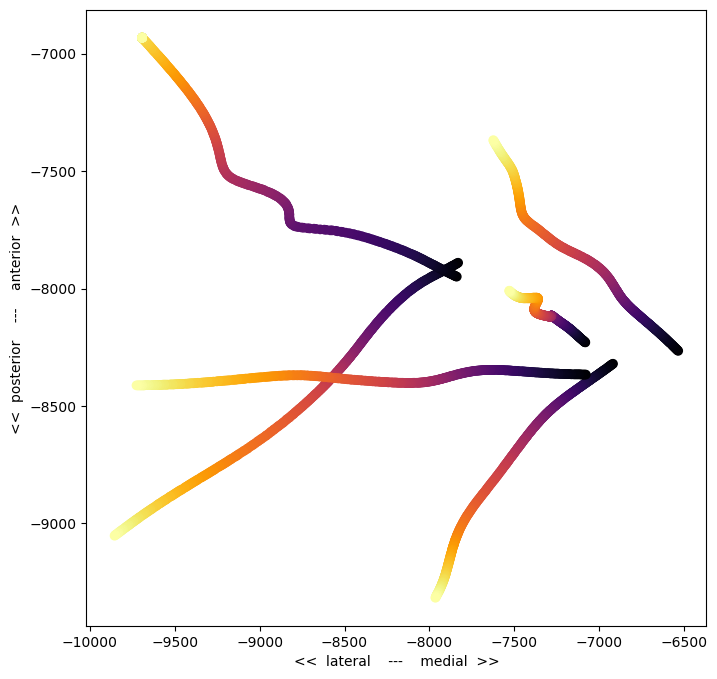

In [17]:
x_coords = loader.session.channels.left_right_ccf_coordinate
y_coords = loader.session.channels.anterior_posterior_ccf_coordinate
color = loader.session.channels.probe_vertical_position

plt.figure(figsize=(8,8))
_ = plt.scatter(-x_coords[x_coords > 0], -y_coords[x_coords > 0], c=color[x_coords > 0], cmap='inferno')
_ = plt.xlabel('<<  lateral    ---    medial  >>')
_ = plt.ylabel('<<  posterior    ---    anterior  >>')

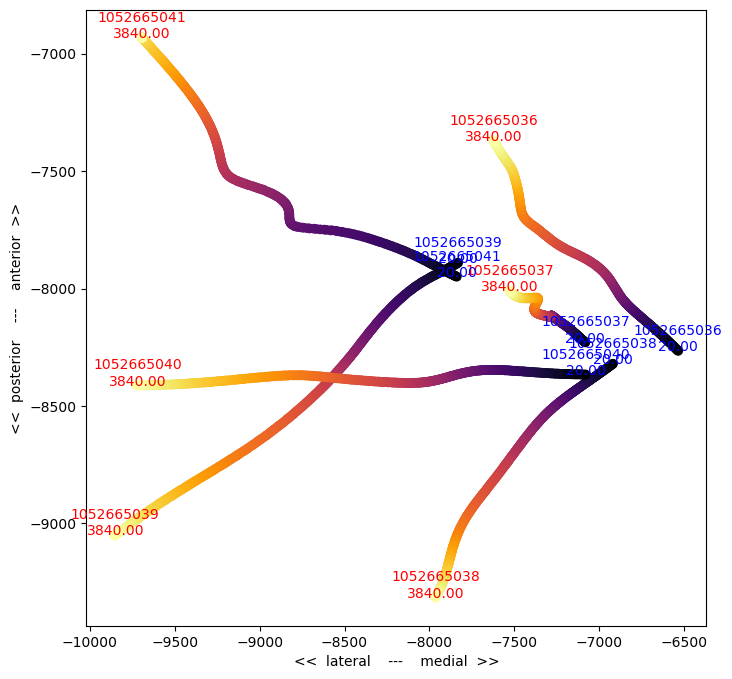

In [18]:

x_coords = loader.session.channels.left_right_ccf_coordinate
y_coords = loader.session.channels.anterior_posterior_ccf_coordinate
color = loader.session.channels.probe_vertical_position
probe_ids = loader.session.channels.probe_id

plt.figure(figsize=(8,8))
_ = plt.scatter(-x_coords[x_coords > 0], -y_coords[x_coords > 0], c=color[x_coords > 0], cmap='inferno')
_ = plt.xlabel('<<  lateral    ---    medial  >>')
_ = plt.ylabel('<<  posterior    ---    anterior  >>')

for pid in probe_ids.unique():
    mask = (probe_ids == pid) & (x_coords > 0)
    if not mask.any():
        continue
    vpos = color[mask]
    min_idx = vpos.idxmin()
    max_idx = vpos.idxmax()
    plt.text(-x_coords[min_idx], -y_coords[min_idx], f'{pid}\n{vpos[min_idx]:.2f}', ha='center', color='blue')
    plt.text(-x_coords[max_idx], -y_coords[max_idx], f'{pid}\n{vpos[max_idx]:.2f}', ha='center', color='red')

plt.show()


In [19]:
# Example usage
filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/DetectingSWRs/United_Pipeline/Filters/sharpwave_componenet_8to40band_1500hz_band.npz'
running_exclusion_periods = []  # Optional
ca1_channel_vert_positions = loader.session.channels.loc[ca1_chans].probe_vertical_position

# Input variables
ca1_lfp=lfp_ca1
lfp_time_index=lfp_time_index
filter_path=filter_path
ca1_chan_ids=ca1_chans
this_chan_id=this_chan_id
channel_positions=ca1_channel_vert_positions
ripple_power=peakrippleband  # Pass your pre-calculated ripple power
running_exclusion_periods=running_exclusion_periods

In [20]:
filter_path

'/home/acampbell/NeuropixelsLFPOnRamp/DetectingSWRs/United_Pipeline/Filters/sharpwave_componenet_8to40band_1500hz_band.npz'

In [21]:
filter_data = np.load(filter_path)
sharpwave_filter = filter_data['sharpwave_componenet_8to40band_1500hz_band']

# Create a simpler exclusion mask using time index
print("Creating exclusion mask...")
mask = np.ones_like(lfp_time_index, dtype=bool)
# Exclude first 3.5 seconds and last 3.5 seconds
mask &= (lfp_time_index > 3.5) & (lfp_time_index < (lfp_time_index[-1] - 3.5))

if running_exclusion_periods:
    for start_time, end_time in running_exclusion_periods:
        mask &= ~((lfp_time_index >= start_time) & (lfp_time_index <= end_time))

# Find channels below the reference
print("Finding channels below reference...")
this_chan_position = channel_positions.loc[this_chan_id]
below_channels_mask = channel_positions > this_chan_position
below_channel_ids = channel_positions[below_channels_mask].index.values
print(f"Found {len(below_channel_ids)} channels below reference.")

# Map channel IDs to indices
chan_id_to_idx = {chan_id: i for i, chan_id in enumerate(ca1_chan_ids)}
below_channel_indices = [chan_id_to_idx[chan_id] for chan_id in below_channel_ids if chan_id in chan_id_to_idx]
print(f"Mapped to {len(below_channel_indices)} valid indices.")

# Get net ripple power
ripple_net_power = np.sum(ripple_power[mask])

# Process all channels
print(f"Processing all {len(below_channel_indices)} channels...")
sw_net_power = np.zeros(len(below_channel_indices))
correlations = np.zeros(len(below_channel_indices))

i = 0
idx = below_channel_indices[0]

if i % 5 == 0:
    print(f"  Processing channel {i+1}/{len(below_channel_indices)}...")

# Apply sharpwave filter using convolve
sw_filtered = fftconvolve(ca1_lfp[:, idx].reshape(-1), sharpwave_filter, mode="same")


Creating exclusion mask...
Finding channels below reference...
Found 5 channels below reference.
Mapped to 5 valid indices.
Processing all 5 channels...
  Processing channel 1/5...


In [22]:
from scipy.signal import fftconvolve
sw_filtered = fftconvolve(ca1_lfp[:, idx].reshape(-1), sharpwave_filter, mode="same")


In [23]:

# Get power
sw_power = np.abs(signal.hilbert(sw_filtered)) ** 2

# Calculate net power
sw_net_power[i] = np.sum(sw_power[mask])

# Calculate correlation
valid_sw = sw_power[mask]
valid_ripple = ripple_power[mask]
correlations[i] = np.corrcoef(valid_sw, valid_ripple)[0, 1]


In [24]:
sw_net_power

array([0.00010168, 0.        , 0.        , 0.        , 0.        ])

In [25]:
correlations

array([-2.10378626e-07,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [26]:
lfp_time_index

array([4.02520915e+00, 4.02587582e+00, 4.02654249e+00, ...,
       9.57757321e+03, 9.57757388e+03, 9.57757454e+03])

In [28]:
plt.plot(depths, swp_power, label="Sharp Wave Power")
plt.plot(depths, ripple_power, label="Ripple Power")
plt.plot(depths, phase_coherence, label="Phase Coherence")
plt.plot(depths, correlation, label="Ripple–SWP Correlation")
plt.legend()


NameError: name 'depths' is not defined

In [ ]:

# Filter to gamma band
gamma_band_ca1 = np.convolve(
    peakripple_chan_raw_lfp.reshape(-1), gamma_filter, mode="same"
)


# create a dummy speed vector
dummy_speed = np.zeros_like(peakrippleband)
print("Detecting Putative Ripples")
# we add a dimension to peakrippleband because the ripple detector needs it
process_stage = f"Detecting Putative Ripples on probe with id {str(probe_id)}"

Karlsson_ripple_times = ripple_detection.Karlsson_ripple_detector(
    time=lfp_time_index,
    zscore_threshold=ripple_band_threshold,
    filtered_lfps=peakrippleband[:, None],
    speed=dummy_speed,
    sampling_frequency=1500.0,
)

Karlsson_ripple_times = Karlsson_ripple_times[
    Karlsson_ripple_times.duration < 0.25
]
print("Done")
# adds some stuff we want to the file

# ripple band power
peakrippleband_power = np.abs(signal.hilbert(peakrippleband)) ** 2
Karlsson_ripple_times["Peak_time"] = peaks_time_of_events(
    events=Karlsson_ripple_times,
    time_values=lfp_time_index,
    signal_values=peakrippleband_power,
)
speed_cols = [
    col for col in Karlsson_ripple_times.columns if "speed" in col
]
Karlsson_ripple_times = Karlsson_ripple_times.drop(columns=speed_cols)
csv_filename = (
    f"probe_{probe_id}_channel_{this_chan_id}_karlsson_detector_events.csv"
)
csv_path = os.path.join(session_subfolder, csv_filename)
#Karlsson_ripple_times.to_csv(csv_path, index=True, compression="gzip")
print("Writing to file.")
print("Detecting gamma events.")

# compute this later, I will have a seperate script called SWR filtering which will do this
process_stage = f"Detecting Gamma Events on probe with id {str(probe_id)}"

gamma_power = np.abs(signal.hilbert(gamma_band_ca1)) ** 2
gamma_times = event_boundary_detector(
    time=lfp_time_index,
    threshold_sd=gamma_event_thresh,
    envelope=False,
    minimum_duration=0.015,
    maximum_duration=float("inf"),
    five_to_fourty_band_power_df=gamma_power,
)
print("Done")
csv_filename = (
    f"probe_{probe_id}_channel_{this_chan_id}_gamma_band_events.csv"
)
csv_path = os.path.join(session_subfolder, csv_filename)
#gamma_times.to_csv(csv_path, index=True, compression="gzip")

# movement artifact detection
process_stage = f"Detecting Movement Artifacts on probe with id {probe_id}"

for i in [0, 1]:
    channel_outside_hp = take_two[i]
    process_stage = f"Detecting Movement Artifacts on control channel {channel_outside_hp} on probe {probe_id}"
    # process control channel ripple times
    ripple_band_control = outof_hp_chans_lfp[i]
    dummy_speed = np.zeros_like(ripple_band_control)
    ripple_band_control = filter_ripple_band(ripple_band_control)
    rip_power_controlchan = np.abs(signal.hilbert(ripple_band_control)) ** 2
    
    print(f"ripple_band_control shape: {ripple_band_control.shape}, length: {len(ripple_band_control)}")
    print(f"lfp_time_index shape: {lfp_time_index.shape}, length: {len(lfp_time_index)}")
    print(f"dummy_speed shape: {dummy_speed.shape}, length: {len(dummy_speed)}")
    
    if DATASET_TO_PROCESS == 'abi_visual_behaviour':
        lfp_time_index = lfp_time_index.reshape(-1)
        dummy_speed = dummy_speed.reshape(-1)
    if DATASET_TO_PROCESS == 'ibl':
        # Reshape to ensure consistent (n_samples, n_channels) format for detector
        # Prevents memory error when pd.notnull() creates boolean arrays with shape (n, n)
        rip_power_controlchan = rip_power_controlchan.reshape(-1,1)
    
    movement_controls = ripple_detection.Karlsson_ripple_detector(
        time=lfp_time_index.reshape(-1),  # if this doesnt work try adding .reshape(-1)
        filtered_lfps=rip_power_controlchan,  # indexing [:,None] is not needed here, rip_power_controlchan is already 2d (nsamples, 1)
        speed=dummy_speed.reshape(-1),  # if this doesnt work try adding .reshape(-1)
        zscore_threshold=movement_artifact_ripple_band_threshold,
        sampling_frequency=1500.0,
    )
    speed_cols = [
        col for col in movement_controls.columns if "speed" in col
    ]
    movement_controls = movement_controls.drop(columns=speed_cols)
    # write to file name
    channel_outside_hp = "channelsrawInd_" + str(channel_outside_hp)  # no cjannel id in IBL dataset, so this will do instead
    csv_filename = f"probe_{probe_id}_channel_{channel_outside_hp}_movement_artifacts.csv"
    csv_path = os.path.join(session_subfolder, csv_filename)
    movement_controls.to_csv(csv_path, index=True, compression="gzip")
    print("Done Probe id " + str(probe_id))


In [ ]:

# deleting the session folder

loader.cleanup()



Starting analysis...
Loading filter...
Filter loaded. Shape: (15000,)
Creating exclusion mask...
Finding channels below reference...
Found 5 channels below reference.
Mapped to 5 valid indices.
Filtering reference channel for phase analysis...
Processing all 5 channels...
  Processing channel 1/5...
Analysis completed in 97.94 seconds.
Sorting results by depth for plotting...
Plotting...
Number of channels analyzed: 5
Channel with highest correlation: 1054293102
Channel with highest phase coherence: 1054293094


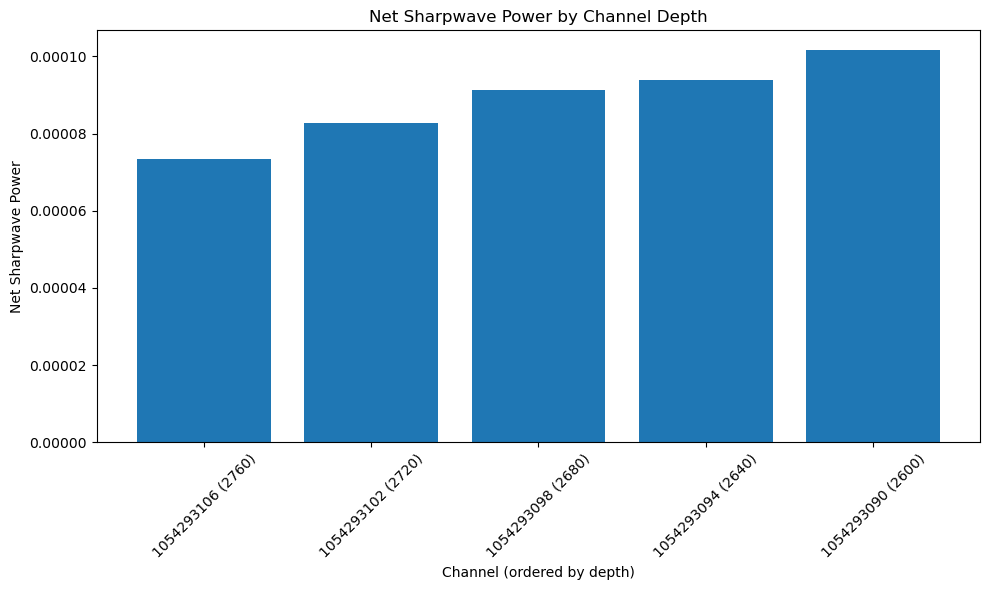

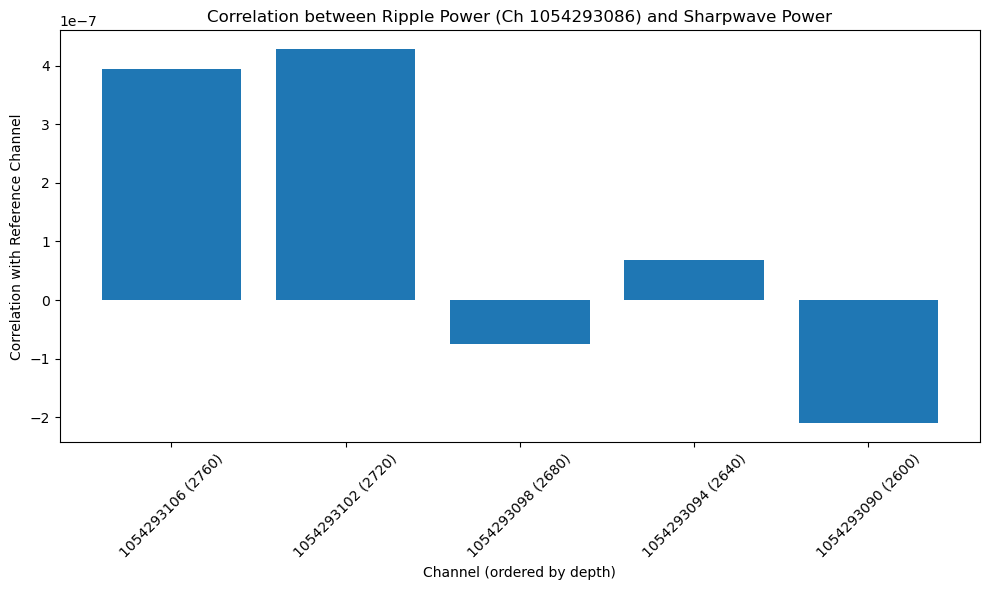

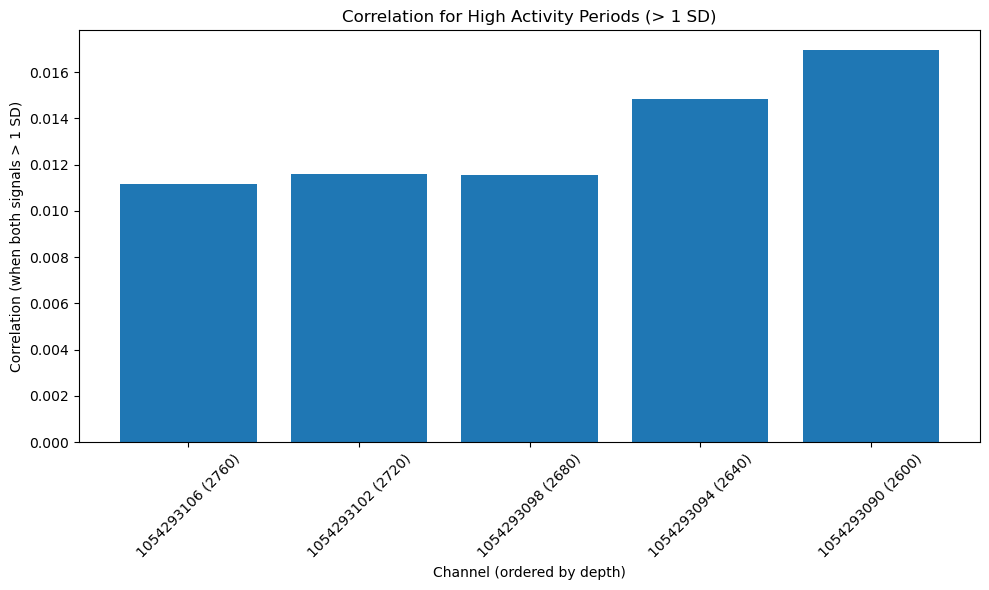

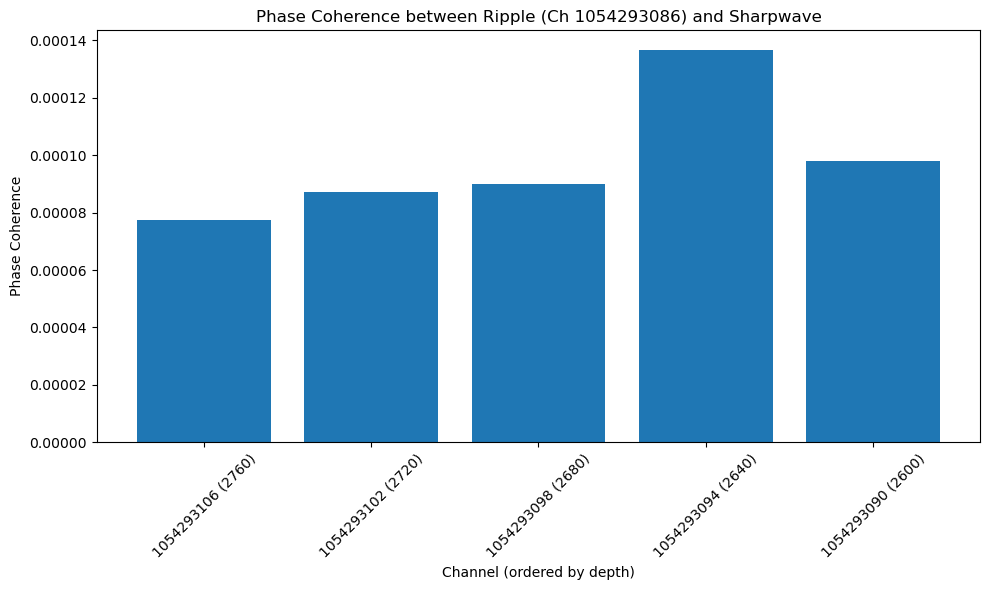

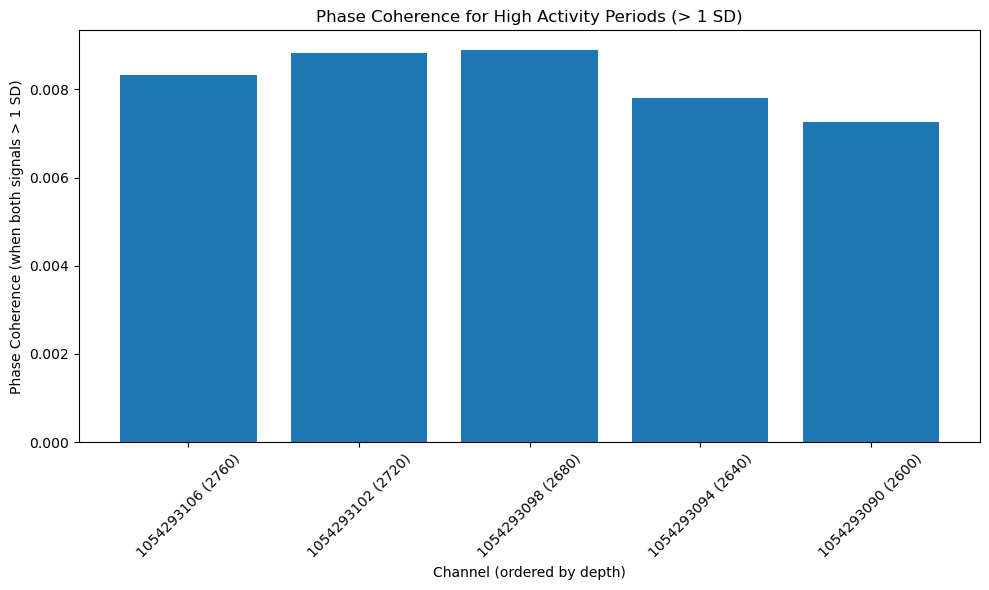

In [27]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import time
from scipy.signal import fftconvolve, hilbert

def analyze_sw_ripple_correlation(ca1_lfp, lfp_time_index, filter_path, ca1_chan_ids, 
                                 this_chan_id, channel_positions, ripple_power, running_exclusion_periods=None):
    print("Starting analysis...")
    start_time = time.time()
    
    # Load the pre-designed filter
    print("Loading filter...")
    filter_data = np.load(filter_path)
    sharpwave_filter = filter_data['sharpwave_componenet_8to40band_1500hz_band']
    print(f"Filter loaded. Shape: {sharpwave_filter.shape}")
    
    # Create exclusion mask
    print("Creating exclusion mask...")
    mask = np.ones_like(lfp_time_index, dtype=bool)
    # Exclude first 3.5 seconds and last 3.5 seconds
    mask &= (lfp_time_index > 3.5) & (lfp_time_index < (lfp_time_index[-1] - 3.5))

    if running_exclusion_periods:
        for start_time, end_time in running_exclusion_periods:
            mask &= ~((lfp_time_index >= start_time) & (lfp_time_index <= end_time))
    
    # Find channels below the reference
    print("Finding channels below reference...")
    this_chan_position = channel_positions.loc[this_chan_id]
    below_channels_mask = channel_positions > this_chan_position
    below_channel_ids = channel_positions[below_channels_mask].index.values
    print(f"Found {len(below_channel_ids)} channels below reference.")
    
    # Map channel IDs to indices
    chan_id_to_idx = {chan_id: i for i, chan_id in enumerate(ca1_chan_ids)}
    below_channel_indices = [chan_id_to_idx[chan_id] for chan_id in below_channel_ids if chan_id in chan_id_to_idx]
    ref_chan_idx = chan_id_to_idx[this_chan_id]
    print(f"Mapped to {len(below_channel_indices)} valid indices.")
    
    # Get net ripple power
    ripple_net_power = np.sum(ripple_power[mask])
    
    # Z-score the ripple power
    ripple_power_z = (ripple_power - np.mean(ripple_power[mask])) / np.std(ripple_power[mask])
    
    # Get ripple filtered signal for reference channel for phase analysis
    print("Filtering reference channel for phase analysis...")
    b, a = signal.butter(3, [150/(1500/2), 250/(1500/2)], btype='bandpass')
    ripple_filtered = signal.filtfilt(b, a, ca1_lfp[:, ref_chan_idx])
    
    # Get analytic signal and extract instantaneous phase of ripple band
    analytic_signal = hilbert(ripple_filtered)
    ripple_phase = np.angle(analytic_signal)
    
    # Process all channels
    print(f"Processing all {len(below_channel_indices)} channels...")
    sw_net_power = np.zeros(len(below_channel_indices))
    correlations = np.zeros(len(below_channel_indices))
    correlations_above_threshold = np.zeros(len(below_channel_indices))
    phase_coherence = np.zeros(len(below_channel_indices))
    phase_coherence_high_power = np.zeros(len(below_channel_indices))
    
    for i, idx in enumerate(below_channel_indices):
        if i % 5 == 0:
            print(f"  Processing channel {i+1}/{len(below_channel_indices)}...")
        
        # Apply sharpwave filter using convolve
        sw_filtered = fftconvolve(ca1_lfp[:, idx].reshape(-1), sharpwave_filter, mode="same")
        
        # Get power
        sw_power = np.abs(hilbert(sw_filtered)) ** 2
        
        # Calculate net power
        sw_net_power[i] = np.sum(sw_power[mask])
        
        # Z-score the sharpwave power
        sw_power_z = (sw_power - np.mean(sw_power[mask])) / np.std(sw_power[mask])
        
        # Calculate correlation for all valid points
        valid_sw = sw_power[mask]
        valid_ripple = ripple_power[mask]
        correlations[i] = np.corrcoef(valid_sw, valid_ripple)[0, 1]
        
        # Create masks for high-power periods
        high_ripple_mask = (ripple_power_z > 1) & mask
        high_sw_mask = (sw_power_z > 1) & mask
        high_both_mask = high_ripple_mask & high_sw_mask
        
        # Calculate correlation only for points where both signals are above 1 SD
        if np.sum(high_both_mask) > 10:  # Need at least some points for meaningful correlation
            correlations_above_threshold[i] = np.corrcoef(
                sw_power[high_both_mask], 
                ripple_power[high_both_mask]
            )[0, 1]
        else:
            correlations_above_threshold[i] = np.nan
        
        # Phase coherence analysis
        # Get instantaneous phase of sharpwave component
        sw_analytic = hilbert(sw_filtered)
        sw_phase = np.angle(sw_analytic)
        
        # Calculate phase coherence for all valid points
        # Phase Locking Value (PLV) = |mean(exp(1j*(phase1-phase2)))|
        phase_diff = ripple_phase - sw_phase
        phase_coherence[i] = np.abs(np.mean(np.exp(1j * phase_diff[mask])))
        
        # Calculate phase coherence only during high-power periods
        if np.sum(high_both_mask) > 10:
            phase_coherence_high_power[i] = np.abs(np.mean(np.exp(1j * phase_diff[high_both_mask])))
        else:
            phase_coherence_high_power[i] = np.nan
    
    print(f"Analysis completed in {time.time() - start_time:.2f} seconds.")
    
    # Sort results by depth (vertical position)
    print("Sorting results by depth for plotting...")
    sorted_results = []
    for i, chan_id in enumerate(below_channel_ids):
        vertical_pos = channel_positions.loc[chan_id]
        sorted_results.append((
            chan_id, 
            vertical_pos, 
            sw_net_power[i], 
            correlations[i],
            correlations_above_threshold[i],
            phase_coherence[i],
            phase_coherence_high_power[i]
        ))

    # Sort by vertical position (descending to have lower values on the right)
    sorted_results.sort(key=lambda x: x[1], reverse=True)

    # Extract the sorted data
    sorted_chan_ids = [x[0] for x in sorted_results]
    sorted_positions = [x[1] for x in sorted_results]
    sorted_sw_power = [x[2] for x in sorted_results]
    sorted_correlations = [x[3] for x in sorted_results]
    sorted_correlations_threshold = [x[4] for x in sorted_results]
    sorted_phase_coherence = [x[5] for x in sorted_results]
    sorted_phase_coherence_high = [x[6] for x in sorted_results]

    # Plot net power by depth
    print("Plotting...")
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_chan_ids)), sorted_sw_power)
    plt.xlabel('Channel (ordered by depth)')
    plt.ylabel('Net Sharpwave Power')
    plt.title('Net Sharpwave Power by Channel Depth')
    plt.xticks(range(len(sorted_chan_ids)), [f"{str(ch_id)} ({pos})" for ch_id, pos in zip(sorted_chan_ids, sorted_positions)], rotation=45)
    plt.tight_layout()

    # Plot correlations by depth
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_chan_ids)), sorted_correlations)
    plt.xlabel('Channel (ordered by depth)')
    plt.ylabel('Correlation with Reference Channel')
    plt.title(f'Correlation between Ripple Power (Ch {this_chan_id}) and Sharpwave Power')
    plt.xticks(range(len(sorted_chan_ids)), [f"{str(ch_id)} ({pos})" for ch_id, pos in zip(sorted_chan_ids, sorted_positions)], rotation=45)
    plt.tight_layout()
    
    # Plot correlations for high-activity periods
    plt.figure(figsize=(10, 6))
    valid_indices = ~np.isnan(sorted_correlations_threshold)
    valid_chan_ids = [ch_id for i, ch_id in enumerate(sorted_chan_ids) if valid_indices[i]]
    valid_positions = [pos for i, pos in enumerate(sorted_positions) if valid_indices[i]]
    valid_correlations = [corr for i, corr in enumerate(sorted_correlations_threshold) if valid_indices[i]]
    
    if sum(valid_indices) > 0:
        plt.bar(range(len(valid_chan_ids)), valid_correlations)
        plt.xlabel('Channel (ordered by depth)')
        plt.ylabel('Correlation (when both signals > 1 SD)')
        plt.title(f'Correlation for High Activity Periods (> 1 SD)')
        plt.xticks(range(len(valid_chan_ids)), [f"{str(ch_id)} ({pos})" for ch_id, pos in zip(valid_chan_ids, valid_positions)], rotation=45)
    else:
        plt.text(0.5, 0.5, "No channels with enough high-activity periods", 
                ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    
    # Plot phase coherence
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_chan_ids)), sorted_phase_coherence)
    plt.xlabel('Channel (ordered by depth)')
    plt.ylabel('Phase Coherence')
    plt.title(f'Phase Coherence between Ripple (Ch {this_chan_id}) and Sharpwave')
    plt.xticks(range(len(sorted_chan_ids)), [f"{str(ch_id)} ({pos})" for ch_id, pos in zip(sorted_chan_ids, sorted_positions)], rotation=45)
    plt.tight_layout()
    
    # Plot phase coherence during high-power periods
    plt.figure(figsize=(10, 6))
    valid_indices = ~np.isnan(sorted_phase_coherence_high)
    valid_chan_ids = [ch_id for i, ch_id in enumerate(sorted_chan_ids) if valid_indices[i]]
    valid_positions = [pos for i, pos in enumerate(sorted_positions) if valid_indices[i]]
    valid_coherence = [coh for i, coh in enumerate(sorted_phase_coherence_high) if valid_indices[i]]
    
    if sum(valid_indices) > 0:
        plt.bar(range(len(valid_chan_ids)), valid_coherence)
        plt.xlabel('Channel (ordered by depth)')
        plt.ylabel('Phase Coherence (when both signals > 1 SD)')
        plt.title(f'Phase Coherence for High Activity Periods (> 1 SD)')
        plt.xticks(range(len(valid_chan_ids)), [f"{str(ch_id)} ({pos})" for ch_id, pos in zip(valid_chan_ids, valid_positions)], rotation=45)
    else:
        plt.text(0.5, 0.5, "No channels with enough high-activity periods", 
                ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()

    # Return the original and sorted results
    return {
        'below_channel_ids': below_channel_ids,
        'correlations': correlations,
        'correlations_above_threshold': correlations_above_threshold,
        'phase_coherence': phase_coherence,
        'phase_coherence_high_power': phase_coherence_high_power,
        'sw_net_power': sw_net_power,
        'ripple_net_power': ripple_net_power,
        'sorted_channel_ids': sorted_chan_ids,
        'sorted_positions': sorted_positions,
        'sorted_sw_power': sorted_sw_power,
        'sorted_correlations': sorted_correlations,
        'sorted_correlations_threshold': sorted_correlations_threshold,
        'sorted_phase_coherence': sorted_phase_coherence,
        'sorted_phase_coherence_high': sorted_phase_coherence_high
    }
    
# Path to your filter file
filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/DetectingSWRs/United_Pipeline/Filters/sharpwave_componenet_8to40band_1500hz_band.npz'

# Get vertical positions of channels
ca1_channel_vert_positions = loader.session.channels.loc[ca1_chans].probe_vertical_position

# Optional: Periods to exclude due to running
running_exclusion_periods = []  # Empty list if you don't have running exclusion periods

# Run the analysis
sw_results = analyze_sw_ripple_correlation(
    ca1_lfp=lfp_ca1,                         # Your CA1 LFP data (samples × channels)
    lfp_time_index=lfp_time_index,           # Time points corresponding to samples
    filter_path=filter_path,                 # Path to your sharpwave filter
    ca1_chan_ids=ca1_chans,                  # Channel IDs
    this_chan_id=this_chan_id,               # Reference channel ID
    channel_positions=ca1_channel_vert_positions,  # Vertical positions
    ripple_power=peakrippleband,             # Pre-calculated ripple power
    running_exclusion_periods=running_exclusion_periods
)

# Print some useful information from the results
print(f"Number of channels analyzed: {len(sw_results['below_channel_ids'])}")
print(f"Channel with highest correlation: {sw_results['sorted_channel_ids'][np.argmax(sw_results['sorted_correlations'])]}")
print(f"Channel with highest phase coherence: {sw_results['sorted_channel_ids'][np.argmax(sw_results['sorted_phase_coherence'])]}")
